# Jewellery Price Optimization with ML: Pricing Data to Refine Pricing Strategies

# 1. Business Understanding
This project aims to leverage machine learning to predict the prices of jewellery pieces. By reducing dependence on gemologists and expensive appraisal experts, this initiative can enhance operational efficiency for jewellery retailers





# Import Libraires

In [57]:
# Essential Configuration
%matplotlib inline
%config InlineBackend.figure_formats = {'retina', 'svg'}

# Core Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from matplotlib import colors as mcolors
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)


# Scikit-learn Libraries

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline


# Display Settings
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Adjust the display width to accommodate all columns

# Seaborn Default Settings
sns.set(
    {
        "figure.figsize": (8, 6)
    },
    style='ticks',
    color_codes=True,
    font_scale=0.8
)

# mlflow
import mlflow
import mlflow.sklearn
import mlflow.xgboost

# other libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import skew
from category_encoders import TargetEncoder
from phik import phik_matrix
import xgboost as xgb
import category_encoders as ce



# 1.0 Data Understanding and Exploratory Data Analysis (EDA)
# 1.1 Load Dataset and Add Column Headers


In [58]:
# Load dataset
df = pd.read_csv('Jewelry_Dataset.csv')

# Add column headers
df.columns = [
    "Order_datetime",
    "Order_ID",
    "Product_ID",
    "SKU_Quantity",
    "Category_ID",
    "Category",
    "Brand_ID",
    "Price_USD",
    "User_ID",
    "Target_Gender",
    "Main_Color",
    "Main_Metal",
    "Main_Gem"
]

# Display first five rows
df.head()


Order_datetime             Order_ID           Product_ID  \
0  2018-12-01 17:38:31 UTC  1924899396621697920  1806829193678291446   
1  2018-12-02 13:53:42 UTC  1925511016616034733  1842214461889315556   
2  2018-12-02 17:44:02 UTC  1925626951238681511  1835566849434059453   
3  2018-12-02 21:30:19 UTC  1925740842841014667  1873936840742928865   
4  2018-12-02 22:09:34 UTC  1925760595336888995  1835566854827934449   

   SKU_Quantity   Category_ID          Category  Brand_ID  Price_USD  \
0             1  1.806829e+18               NaN       NaN     212.14   
1             1  1.806829e+18   jewelry.pendant       1.0      54.66   
2             1  1.806829e+18   jewelry.pendant       0.0      88.90   
3             1  1.806829e+18  jewelry.necklace       0.0     417.67   
4             1  1.806829e+18   jewelry.earring       1.0     102.27   

        User_ID Target_Gender Main_Color Main_Metal  Main_Gem  
0  1.515916e+18           NaN     yellow       gold       NaN  
1  1.515916e+18             f      white       gold  sapphire  
2  1.515916e+18             f        red       gold   diamond  
3  1.515916e+18           NaN        red       gold  amethyst  
4  1.515916e+18           NaN        red       gold       NaN

# Data Description:

The features contained in the dataset are:
1. Order datetime: The time at which the order was placed.
2. Order ID: Identifiers for the different orders placed.
3. Purchased product ID: Identifiers for the different product ordered for.
4. Quantity of SKU in the order: Quantity of jewelry pieces ordered for.
5. Category ID: Identifier for the jewelry category.
6. Category alias: Name of jewelry category e.g. earring.
7. Brand ID: Identifier for jeweler brand
8. Price in USD: Jewelry price in US Dollars
9. User ID: Identifier for user/customer
10. Product gender (for male/female) (Target gender for jewelry piece)
11. Main Color: Overall color of jewelry piece
12. Main metal: Main metal used for mounting
13. Main gem: Main gem mounted on jewelry piece


# 1.2 Dataset Summary

In [3]:
# Check dataset shape
print(f"The Dataset shape is: {df.shape}")

print("----------------------------------")

# Dataset info
df.info()


The Dataset shape is: (95910, 13)
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95910 entries, 0 to 95909
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order_datetime  95910 non-null  object 
 1   Order_ID        95910 non-null  int64  
 2   Product_ID      95910 non-null  int64  
 3   SKU_Quantity    95910 non-null  int64  
 4   Category_ID     90558 non-null  float64
 5   Category        85977 non-null  object 
 6   Brand_ID        91125 non-null  float64
 7   Price_USD       90558 non-null  float64
 8   User_ID         90558 non-null  float64
 9   Target_Gender   47743 non-null  object 
 10  Main_Color      88250 non-null  object 
 11  Main_Metal      90448 non-null  object 
 12  Main_Gem        61852 non-null  object 
dtypes: float64(4), int64(3), object(6)
memory usage: 9.5+ MB


In [4]:
# Check for missing values and percentage of missing values
missing_values = df.isnull().sum()
missing_percentage = 100 * df.isnull().sum() / len(df)

# Combine the results into a single DataFrame for better readability
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print("Missing Value Description:")
print(missing_summary)


Missing Value Description:
                Missing Values  Percentage
Order_datetime               0    0.000000
Order_ID                     0    0.000000
Product_ID                   0    0.000000
SKU_Quantity                 0    0.000000
Category_ID               5352    5.580231
Category                  9933   10.356584
Brand_ID                  4785    4.989052
Price_USD                 5352    5.580231
User_ID                   5352    5.580231
Target_Gender            48167   50.221041
Main_Color                7660    7.986654
Main_Metal                5462    5.694922
Main_Gem                 34058   35.510374


In [5]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

print("---------------------------------------")

# Check unique values
print(f"Unique values:\n{df.nunique()}")


The dataset contains 2589 duplicate rows that need to be removed.
---------------------------------------
Unique values:
Order_datetime    74504
Order_ID          74759
Product_ID         9613
SKU_Quantity          1
Category_ID          25
Category            218
Brand_ID           2537
Price_USD          3166
User_ID           31079
Target_Gender         2
Main_Color            5
Main_Metal            3
Main_Gem             30
dtype: int64


In [6]:
# Create a DataFrame with counts and percentages -Target Gender Distribution
gender_distribution = pd.DataFrame({
    'Count': df['Target_Gender'].value_counts(),
    'Percentage (%)': df['Target_Gender'].value_counts(normalize=True) * 100
}).reset_index()

# Rename columns for clarity
gender_distribution.columns = ['Target Gender', 'Count', 'Percentage (%)']

# Display the DataFrame
gender_distribution


Target Gender  Count  Percentage (%)
0             f  47379       99.237585
1             m    364        0.762415

In [7]:
# Check unique values for categorical features
print("Unique Values in Categorical Features:")
print("---------------------------------------")
print(f"1. Target Gender: {df['Target_Gender'].unique()}")
print("---------------------------------------")
print(f"2. Main Color: {df['Main_Color'].unique()}")
print("---------------------------------------")
print(f"3. Main Metal: {df['Main_Metal'].unique()}")
print("---------------------------------------")
print(f"4. Main Gem: {df['Main_Gem'].unique()}")
print("---------------------------------------")
print(f"5. Category: {df['Category'].unique()}")


Unique Values in Categorical Features:
---------------------------------------
1. Target Gender: [nan 'f' 'm']
---------------------------------------
2. Main Color: ['yellow' 'white' 'red' nan 'unknown-color' 'black']
---------------------------------------
3. Main Metal: ['gold' 'silver' nan 'platinum']
---------------------------------------
4. Main Gem: [nan 'sapphire' 'diamond' 'amethyst' 'fianit' 'pearl' 'quartz' 'topaz'
 'garnet' 'quartz_smoky' 'ruby' 'agate' 'mix' 'citrine' 'emerald' 'amber'
 'chrysolite' 'chrysoprase' 'nanocrystal' 'turquoise' 'sitall'
 'corundum_synthetic' 'coral' 'onyx' 'nacre' 'spinel' 'tourmaline'
 'emerald_geothermal' 'garnet_synthetic' 'rhodolite' 'sapphire_geothermal']
---------------------------------------
5. Category: [nan 'jewelry.pendant' 'jewelry.necklace' 'jewelry.earring' 'jewelry.ring'
 'jewelry.brooch' 'jewelry.bracelet' 'electronics.clocks'
 'jewelry.souvenir' '230.12' '202.36' '1098.03' '321.78' '1128.62' '81.27'
 '34.25' '582.16' '227.37' '

# 1.3 Statistical Analysis

In [8]:
# Summary statistics
df.describe(include='all').round(2)

Order_datetime      Order_ID    Product_ID  SKU_Quantity  \
count                     95910  9.591000e+04  9.591000e+04       95910.0   
unique                    74504           NaN           NaN           NaN   
top     2020-10-17 12:58:28 UTC           NaN           NaN           NaN   
freq                         26           NaN           NaN           NaN   
mean                        NaN  2.485191e+18  1.815970e+18           1.0   
std                         NaN  1.934750e+17  2.136814e+17           0.0   
min                         NaN  1.924899e+18  1.313551e+18           1.0   
25%                         NaN  2.379732e+18  1.515966e+18           1.0   
50%                         NaN  2.524282e+18  1.956664e+18           1.0   
75%                         NaN  2.644347e+18  1.956664e+18           1.0   
max                         NaN  2.719022e+18  2.541962e+18           1.0   

         Category_ID         Category      Brand_ID  Price_USD       User_ID  \
count   9.055800e+04            85977  9.112500e+04   90558.00  9.055800e+04   
unique           NaN              218           NaN        NaN           NaN   
top              NaN  jewelry.earring           NaN        NaN           NaN   
freq             NaN            29051           NaN        NaN           NaN   
mean    1.805947e+18              NaN  8.891036e+16     362.21  1.512644e+18   
std     2.083954e+16              NaN  3.559651e+17     444.16  2.374776e+16   
min     1.313678e+18              NaN  0.000000e+00       0.99  1.313554e+18   
25%     1.806829e+18              NaN  0.000000e+00     145.62  1.515916e+18   
50%     1.806829e+18              NaN  1.000000e+00     258.77  1.515916e+18   
75%     1.806829e+18              NaN  1.000000e+00     431.37  1.515916e+18   
max     1.806829e+18              NaN  1.550613e+18   34448.60  1.554297e+18   

       Target_Gender Main_Color Main_Metal Main_Gem  
count          47743      88250      90448    61852  
unique             2          5          3       30  
top                f        red       gold  diamond  
freq           47379      69510      89081    29609  
mean             NaN        NaN        NaN      NaN  
std              NaN        NaN        NaN      NaN  
min              NaN        NaN        NaN      NaN  
25%              NaN        NaN        NaN      NaN  
50%              NaN        NaN        NaN      NaN  
75%              NaN        NaN        NaN      NaN  
max              NaN        NaN        NaN      NaN


# Initial observations - Data Overview:

1. Data Summary:
  * Dataset Size: 95,910 rows and 13 features.
  * Features: Includes order details, jewellery categories, user demographics, material attributes, and the target variable (price).
  * Key Observations:
  * Missing Values: 9 columns with missing values. Critical missing data in Target_Gender (48,000 rows) and Main_Gem (34,000 rows).

2. Duplicates: 2,589 duplicate rows.

3. Feature Variety: Low variety in Target_Gender, SKU_Quantity, Main_Color, and Main_Metal.
4. Outliers in Price: Price ranges from $0.99 to $34,448.60, indicating possible outliers or premium items.

**Data Quality Issues:**

  * Incorrect values in Category (e.g., '451.10', '283.49') need correction.
  * Next Steps for Data Preparation
  * Address missing values and duplicates.
  * Correct inconsistent or corrupt entries.
  * Handle outliers in the price feature.
  * Normalize categorical and numerical features for modeling

# 1.4 Features Distribution Analysis
# 1.4.1 Price Distribution 

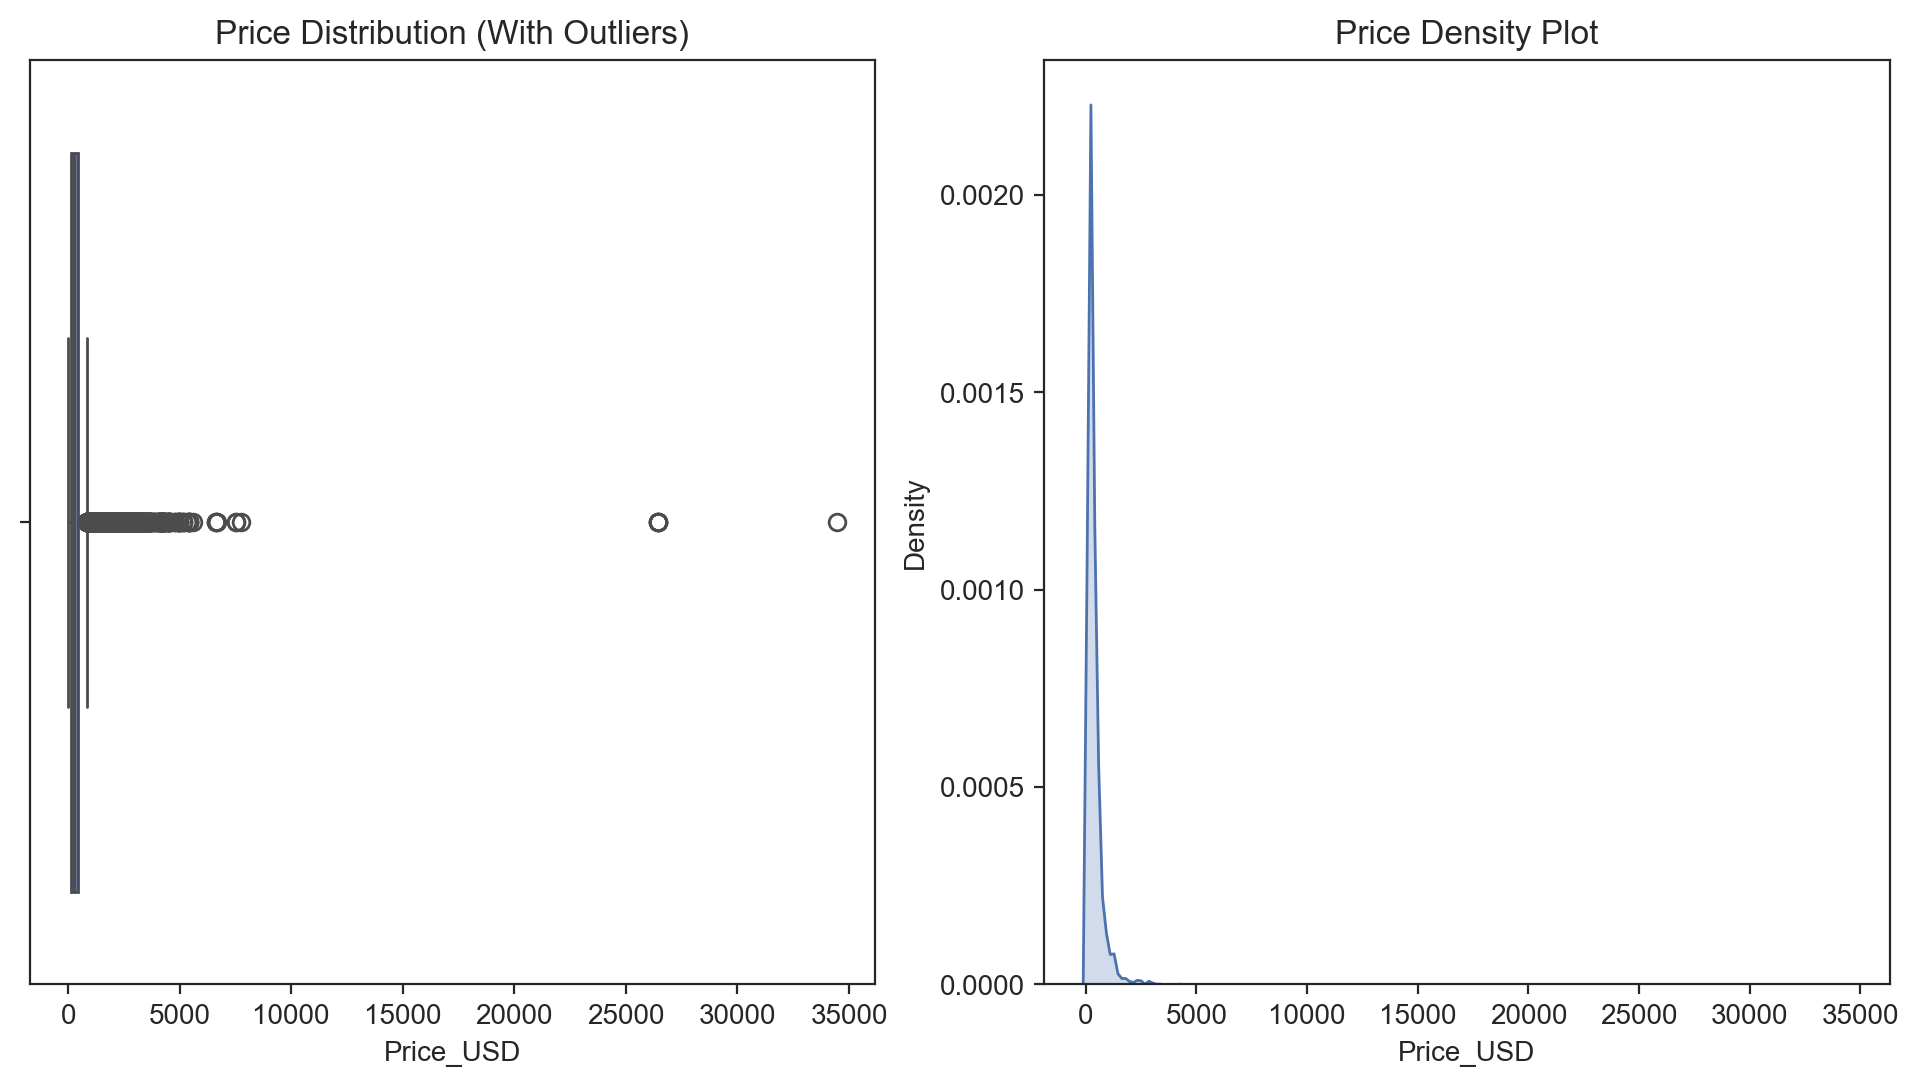

The Price skewness: 18.95906072625981
The Price kurtosis: 1054.8979068506155


In [9]:
# Distribution of Price_USD
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Price_USD', showfliers=True)
plt.title("Price Distribution (With Outliers)")

plt.subplot(1, 2, 2)
sns.kdeplot(data=df['Price_USD'], shade=True)
plt.title("Price Density Plot")
plt.show()

# Check skewness and kurtosis of Price_USD
print(f"The Price skewness: {df['Price_USD'].skew()}")
print(f"The Price kurtosis: {df['Price_USD'].kurtosis()}")


# Comment:
**Price Distribution**
  * Range: £30.99 to £34,448.60.
  * Mean: £362.21; Standard Deviation: £444.16.
  * Skewness: 18.96; Kurtosis: 1054.90.

The above analysis Indicates a highly right-skewed distribution with potential outliers.

# 1.4.2 Univariate Analysis of Categorical Features

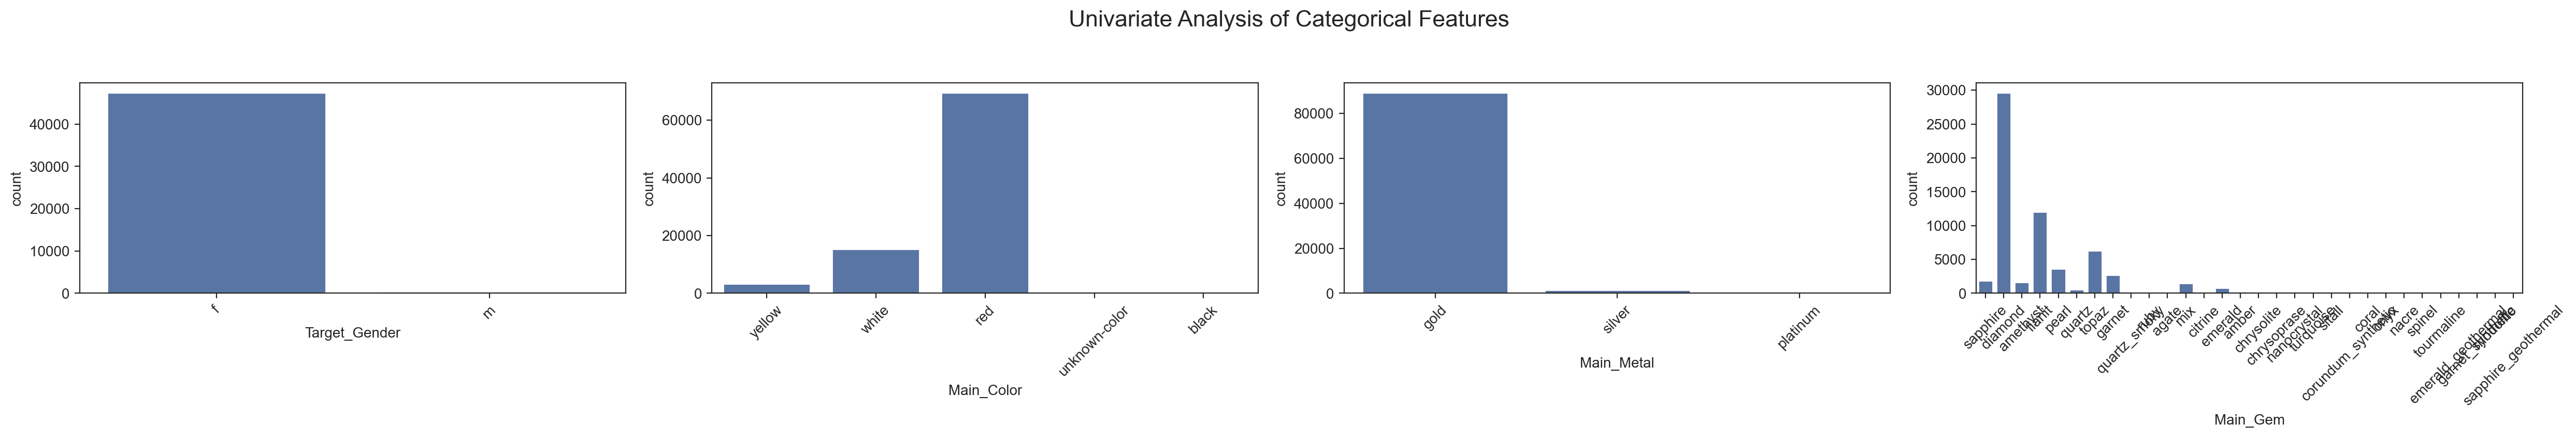

In [5]:
#Categorical features - Univaraite analysis
categorical_features = ['Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']

fig, axes = plt.subplots(1, len(categorical_features), figsize=(25, 4))
plt.suptitle("Univariate Analysis of Categorical Features", fontsize=16, y=1.05)

for i, col in enumerate(categorical_features):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Comment:
**Categorical Features Distribution**

**Target Gender:**

  * Female Buyers: 99.24%.
  * Male Buyers: 0.76%.

**Main Colors:** ['Yellow', 'White', 'Red', 'Black'].
  * Most common: Red (69,510 occurrences).

**Main Metals:** ['Gold', 'Silver', 'Platinum'].
  * Most common: Gold (89,081 occurrences).

**Main Gems:** ['Sapphire', 'Diamond', 'Amethyst', 'Fianit', 'Pearl', 'Quartz', 'Topaz', etc.].
  * Most common: Diamond (29,609 occurrences).

# 2.0 Data Preprocessing
# 2.1 Filter Relevant Jewellery Categories

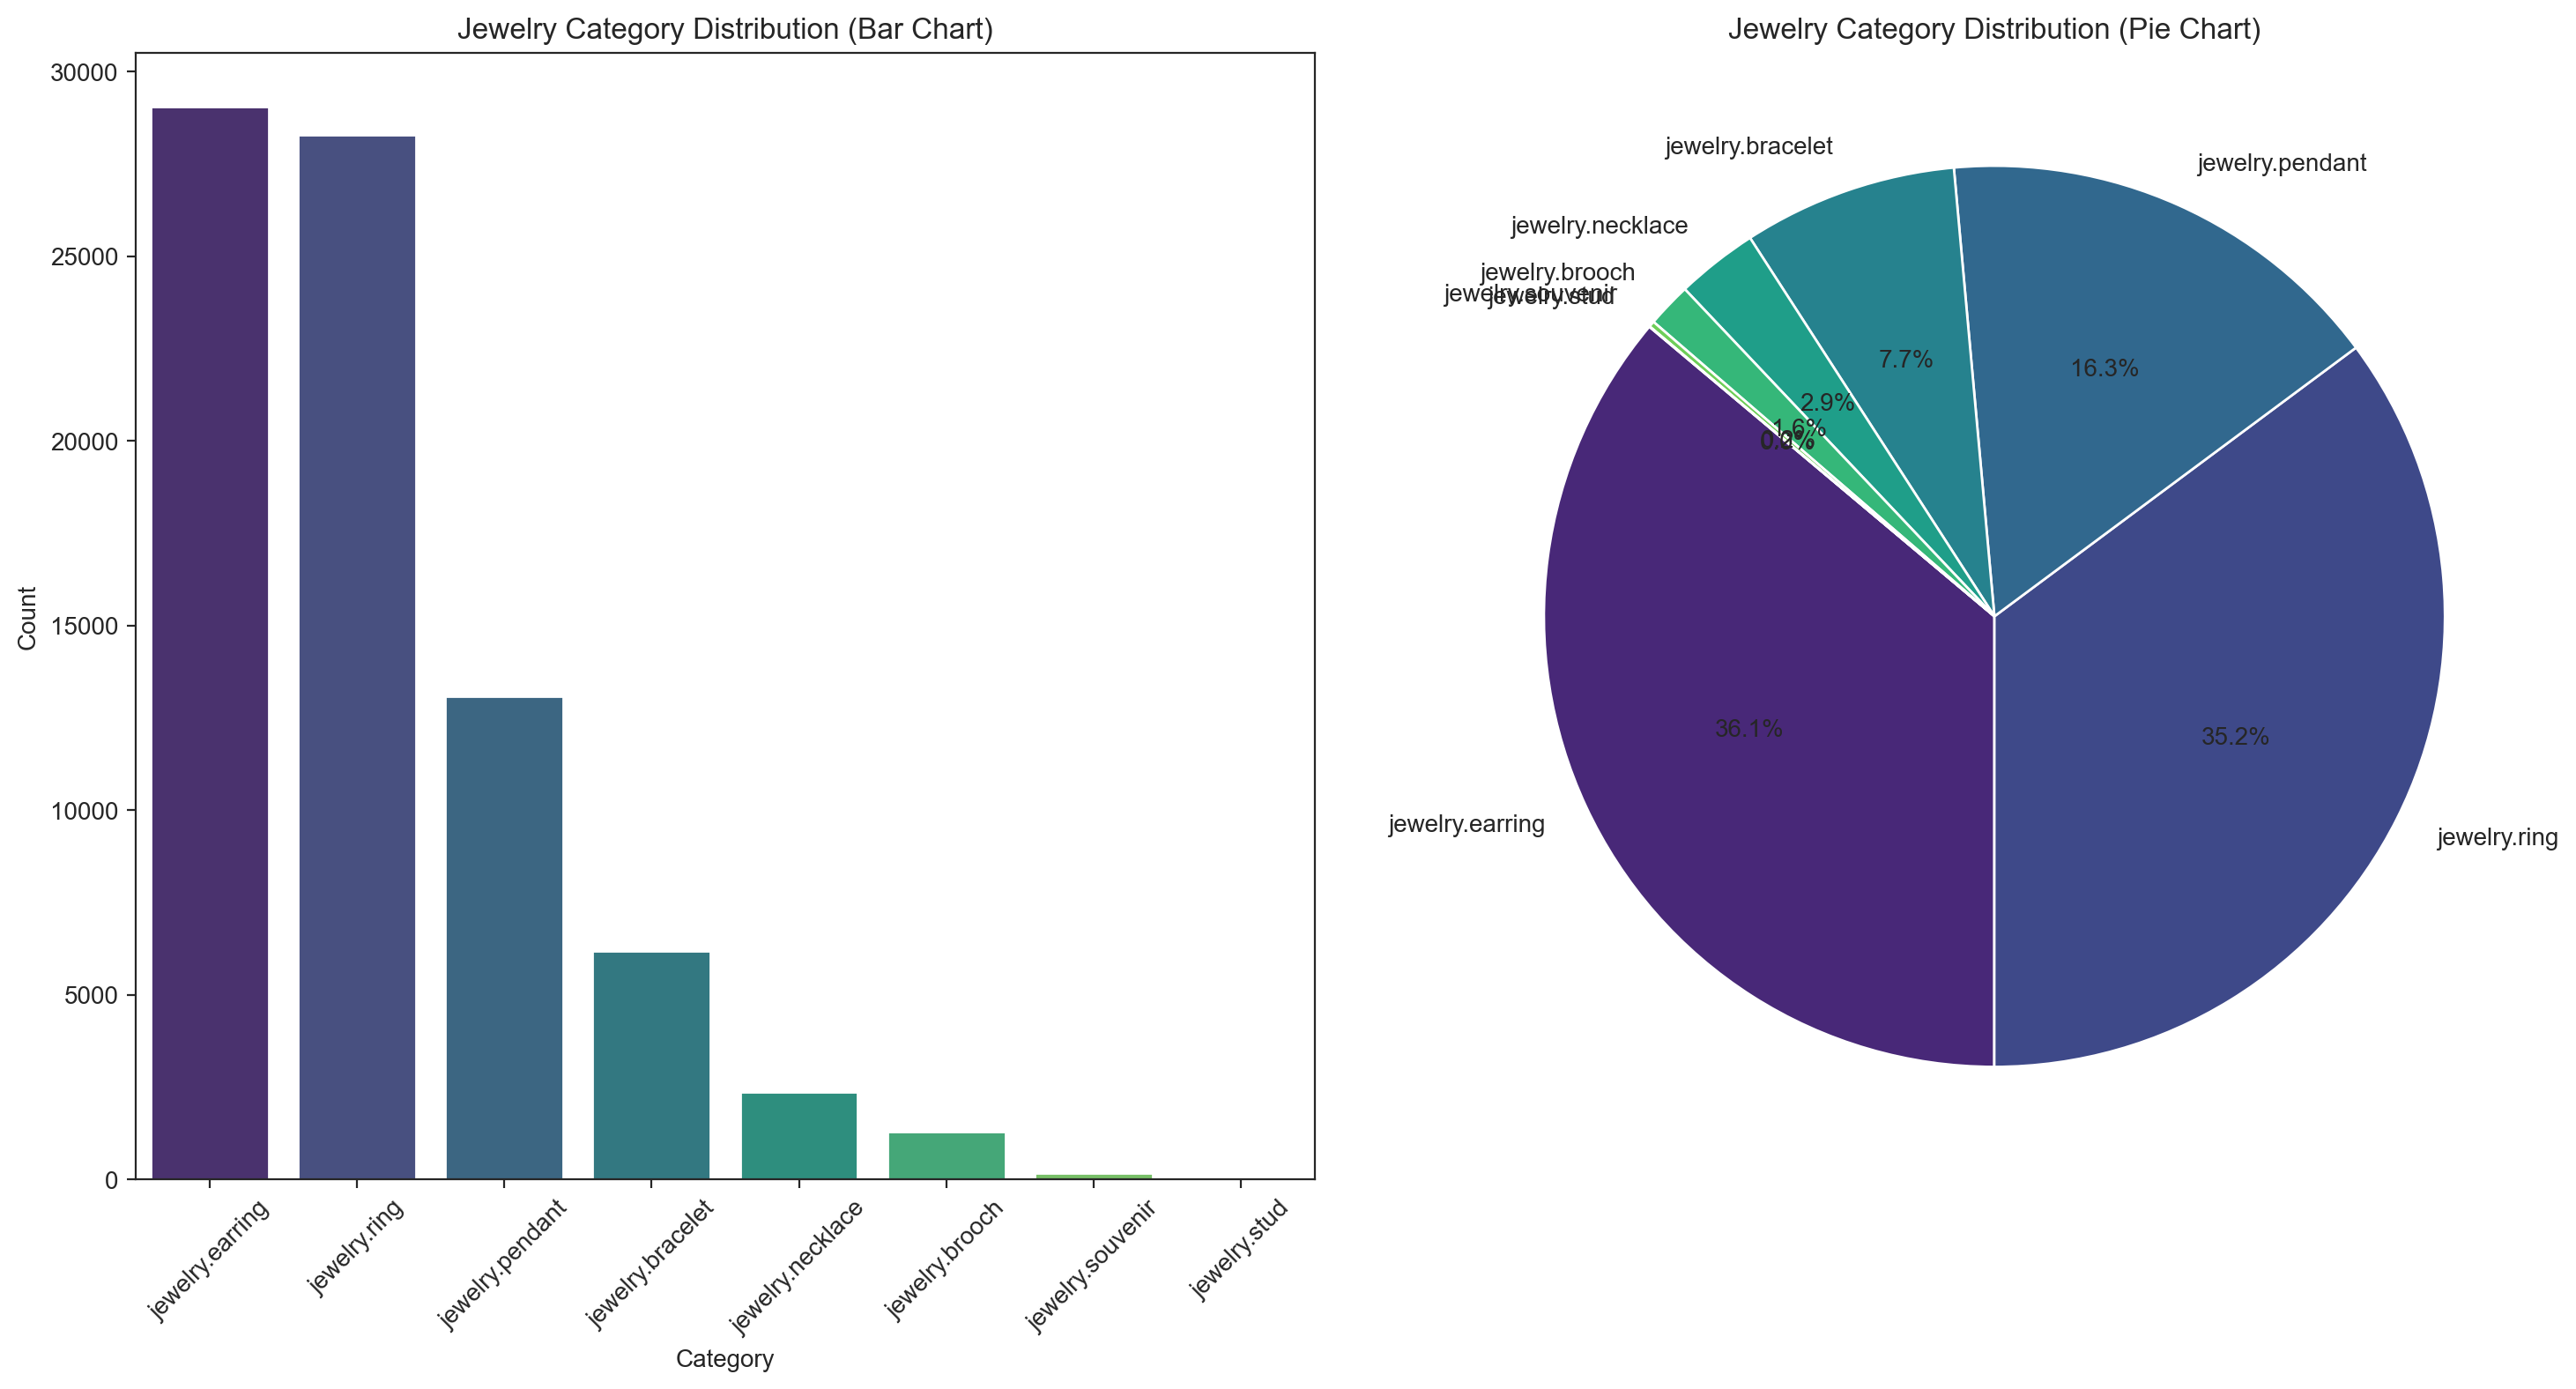

In [59]:
# Filter jewelry-related categories
jewelry_categories = [
    'jewelry.pendant', 'jewelry.necklace', 'jewelry.earring', 
    'jewelry.ring', 'jewelry.brooch', 'jewelry.bracelet',
    'jewelry.souvenir', 'jewelry.stud'
]
df_cleaned = df[df['Category'].isin(jewelry_categories)].reset_index(drop=True)

# Prepare data for visualization
category_counts = df_cleaned['Category'].value_counts()

# Create the figure and axes for side-by-side charts
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Bar chart
sns.barplot(x=category_counts.index, y=category_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Jewelry Category Distribution (Bar Chart)")
axes[0].set_xticklabels(category_counts.index, rotation=45)
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Count")

# Pie chart
axes[1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(category_counts)))
axes[1].set_title("Jewelry Category Distribution (Pie Chart)")

# Adjust layout
plt.tight_layout()
plt.show()


# Comment:

**Filter Relevant Categories and Conduct EDA**
**Corrupt Data Removed:** 15,000 rows (16% of the dataset) from the 'Category' feature due to errors.

**Insights Post-Cleanup:**
Earrings, rings, and pendants account for 87% of sales.

**Jewelry Categories:** ['Jewelry.Pendant', 'Jewelry.Necklace', 'Jewelry.Earring', 'Jewelry.Ring', 'Jewelry.Brooch', 'Jewelry.Bracelet', 'Jewelry.Souvenir'].
  * Most common: Jewelry.Earring (29,051 occurrences).


# 2.1.1 Jewellery Category by Gender


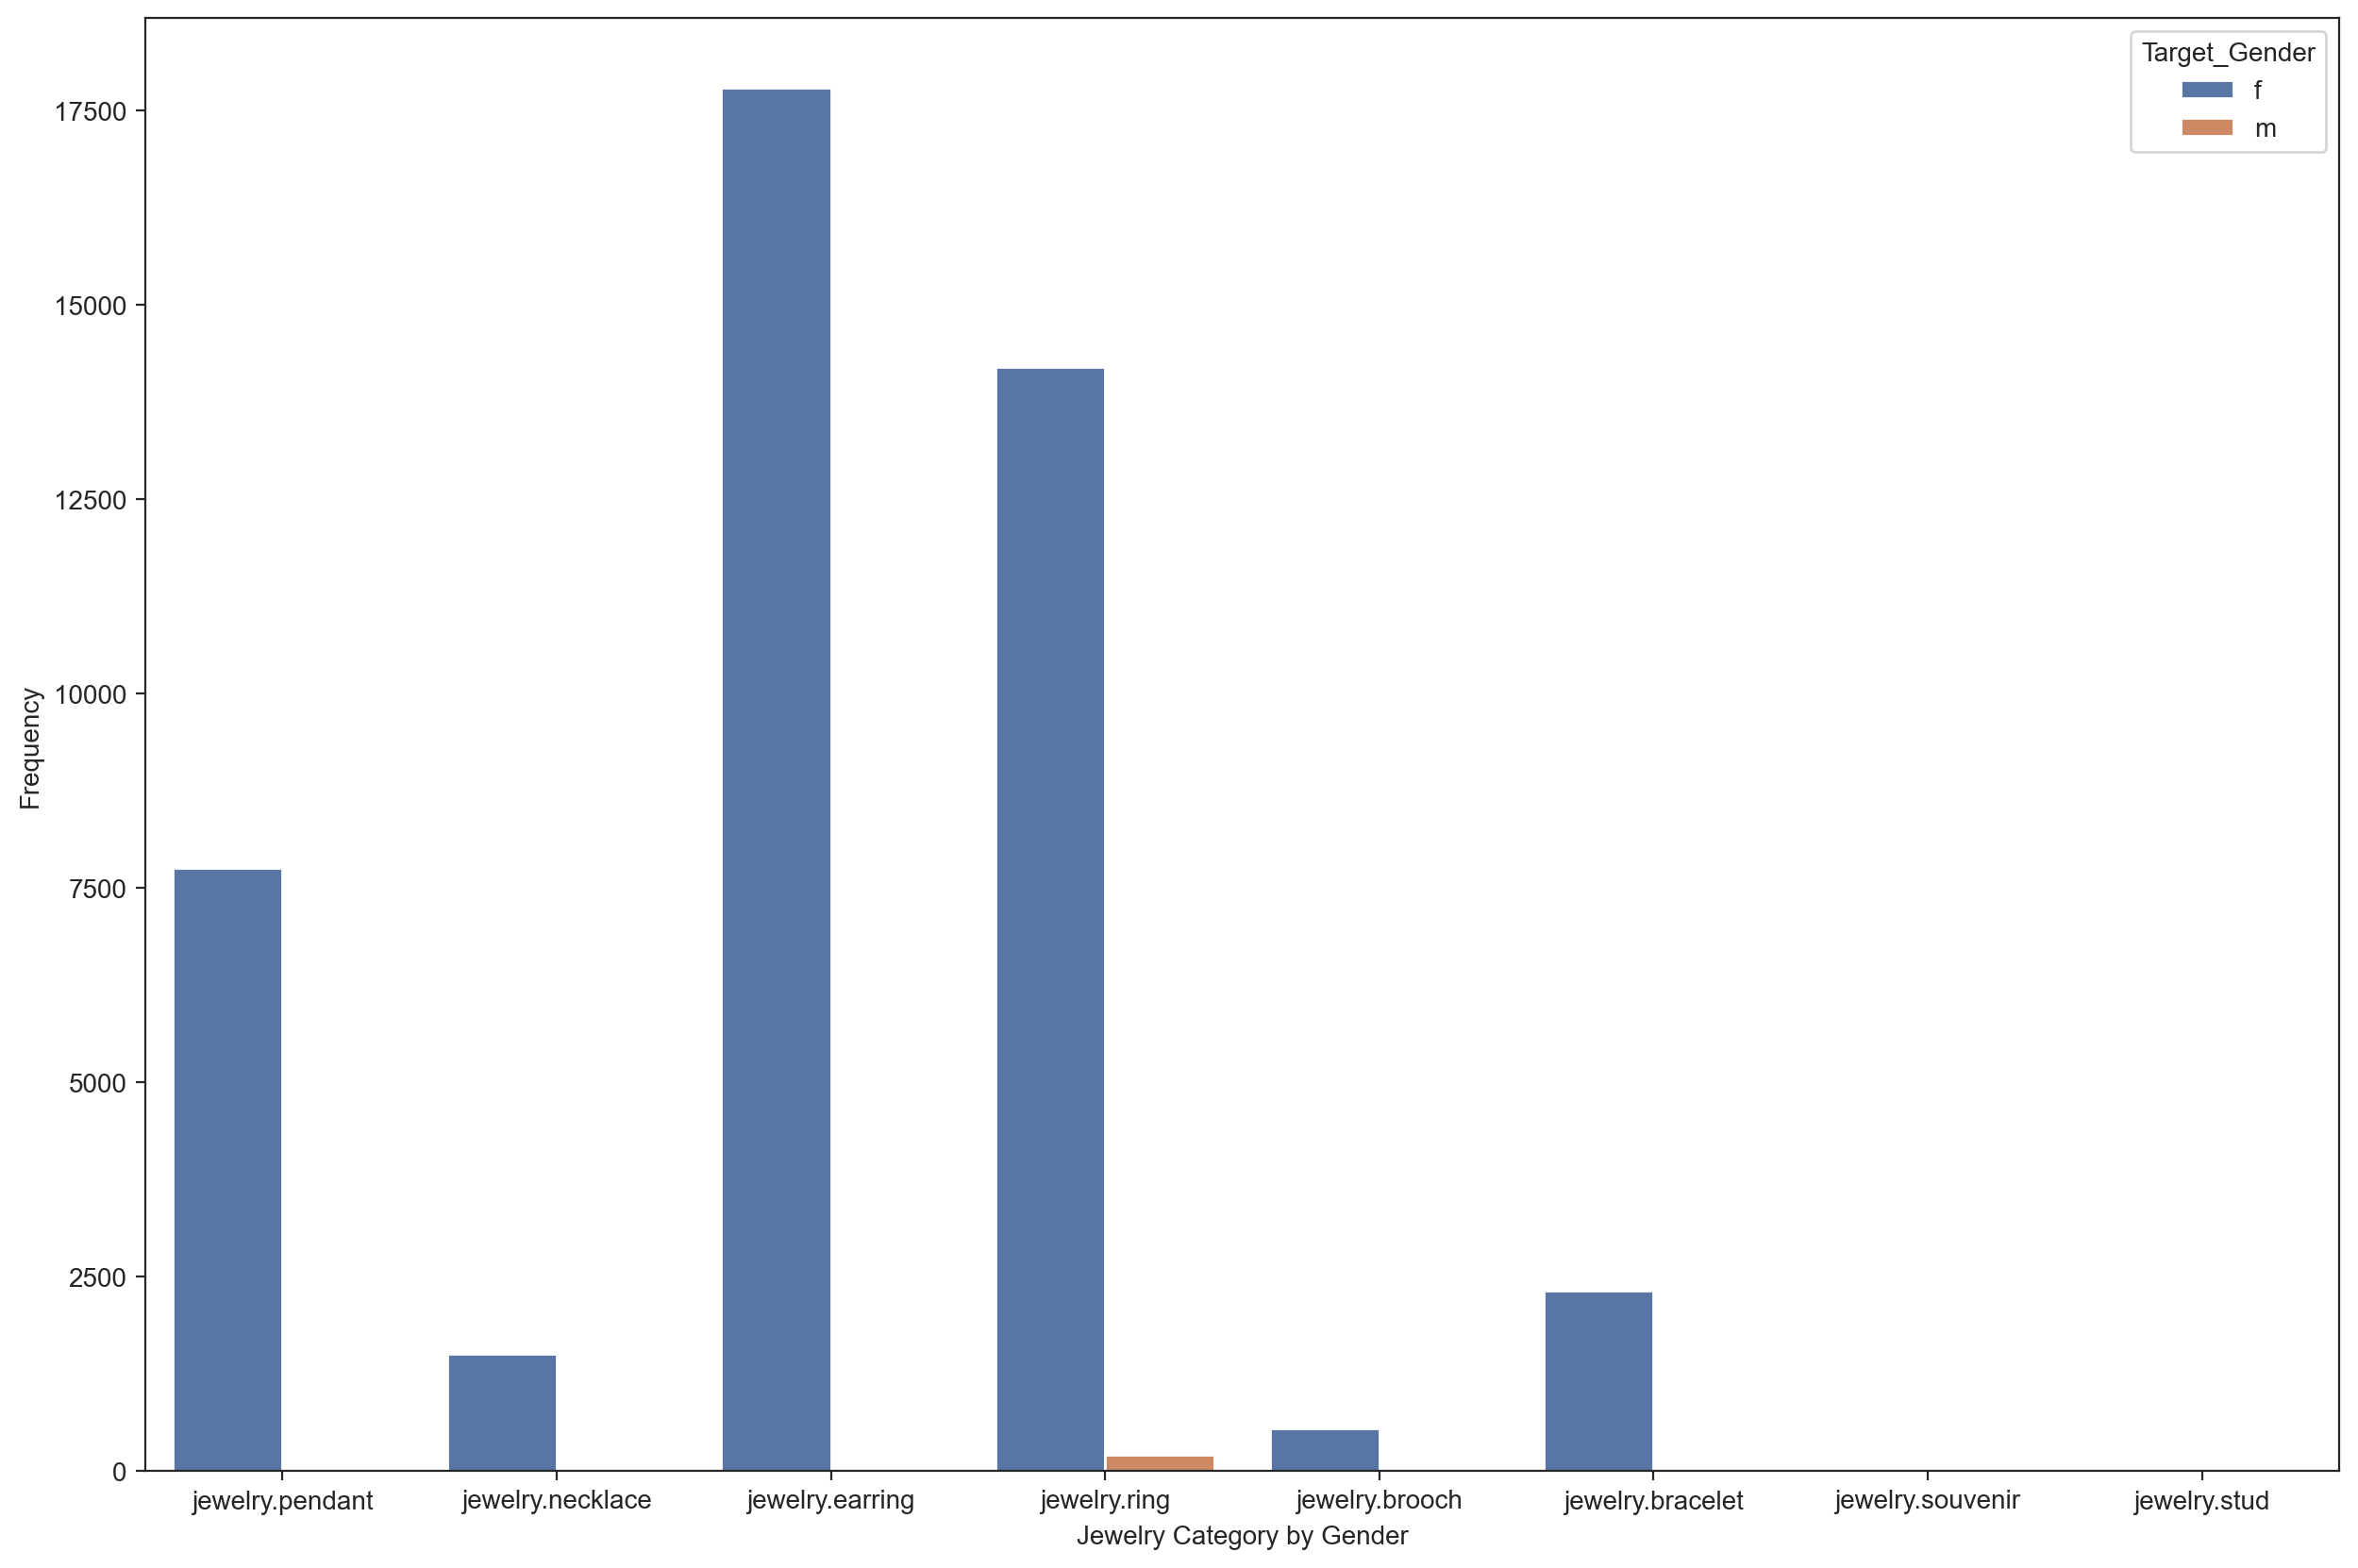

In [8]:
# Jewelry category by gender
plt.figure(figsize=(15,10))

sns.countplot(data = df_cleaned, x = 'Category', hue = 'Target_Gender')

plt.xlabel("Jewelry Category by Gender")
plt.ylabel("Frequency")
plt.show()

# Comment:

**Female buyers:** Over 90%, primarily purchasing earrings, rings, and pendants.

**Male buyers:** Represent <1% of the sales, primarily in the ring category.

# 2.2 Handle Missing Values

In [60]:
def impute_missing_values(data, numerical_features, categorical_features):
    # Impute numerical features with mean
    num_imputer = SimpleImputer(strategy='most_frequent')
    data[numerical_features] = num_imputer.fit_transform(data[numerical_features])
    
    # Impute categorical features with mode
    cat_imputer = SimpleImputer(strategy='most_frequent')
    data[categorical_features] = cat_imputer.fit_transform(data[categorical_features])
    
    return data

# Define feature types
categorical_features = ['Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']
numerical_features = ['Brand_ID']

# Impute missing values
df_cleaned = impute_missing_values(df_cleaned, numerical_features, categorical_features)
print("Missing values handled successfully!")


Missing values handled successfully!


# 2.3 Handle Duplicates Rows

In [62]:
# Display the number of duplicate rows
num_duplicates = df_cleaned.duplicated().sum()
print(f"The dataset contains {num_duplicates} duplicate rows that need to be removed.")


# Drop duplicate rows
df_cleaned = df_cleaned.drop_duplicates()


The dataset contains 2371 duplicate rows that need to be removed.


# Comment:
  * 2,371 duplicares were removed from the data.

# 2.3 Drop Irrelevant Columns

In [63]:
# Drop unnecessary columns
columns_to_drop = ['Order_datetime', 'Order_ID', 'Product_ID', 'SKU_Quantity', 'Category_ID', 'User_ID']
df_cleaned.drop(columns=columns_to_drop, inplace=True)

# Display the cleaned dataset
df_cleaned.head()


Category  Brand_ID  Price_USD Target_Gender Main_Color Main_Metal  \
0   jewelry.pendant       1.0      54.66             f      white       gold   
1   jewelry.pendant       0.0      88.90             f        red       gold   
2  jewelry.necklace       0.0     417.67             f        red       gold   
3   jewelry.earring       1.0     102.27             f        red       gold   
4   jewelry.earring       0.0     150.55             f        red       gold   

   Main_Gem  
0  sapphire  
1   diamond  
2  amethyst  
3   diamond  
4   diamond

# Comment:

**Drop Irrelevant Features:**

**Removed Features:**

**Order_datetime, Order_ID, Product_ID, SKU_Quantity, Category_ID, Brand_ID, User_ID.**

**Reason:** No meaningful contribution to price prediction.

**Retained Features:**

**Category, Brand, Price_USD, Target_Gender, Main_Color, Main_Metal, Main_Gem.**

# 2.4 Outlier Detection

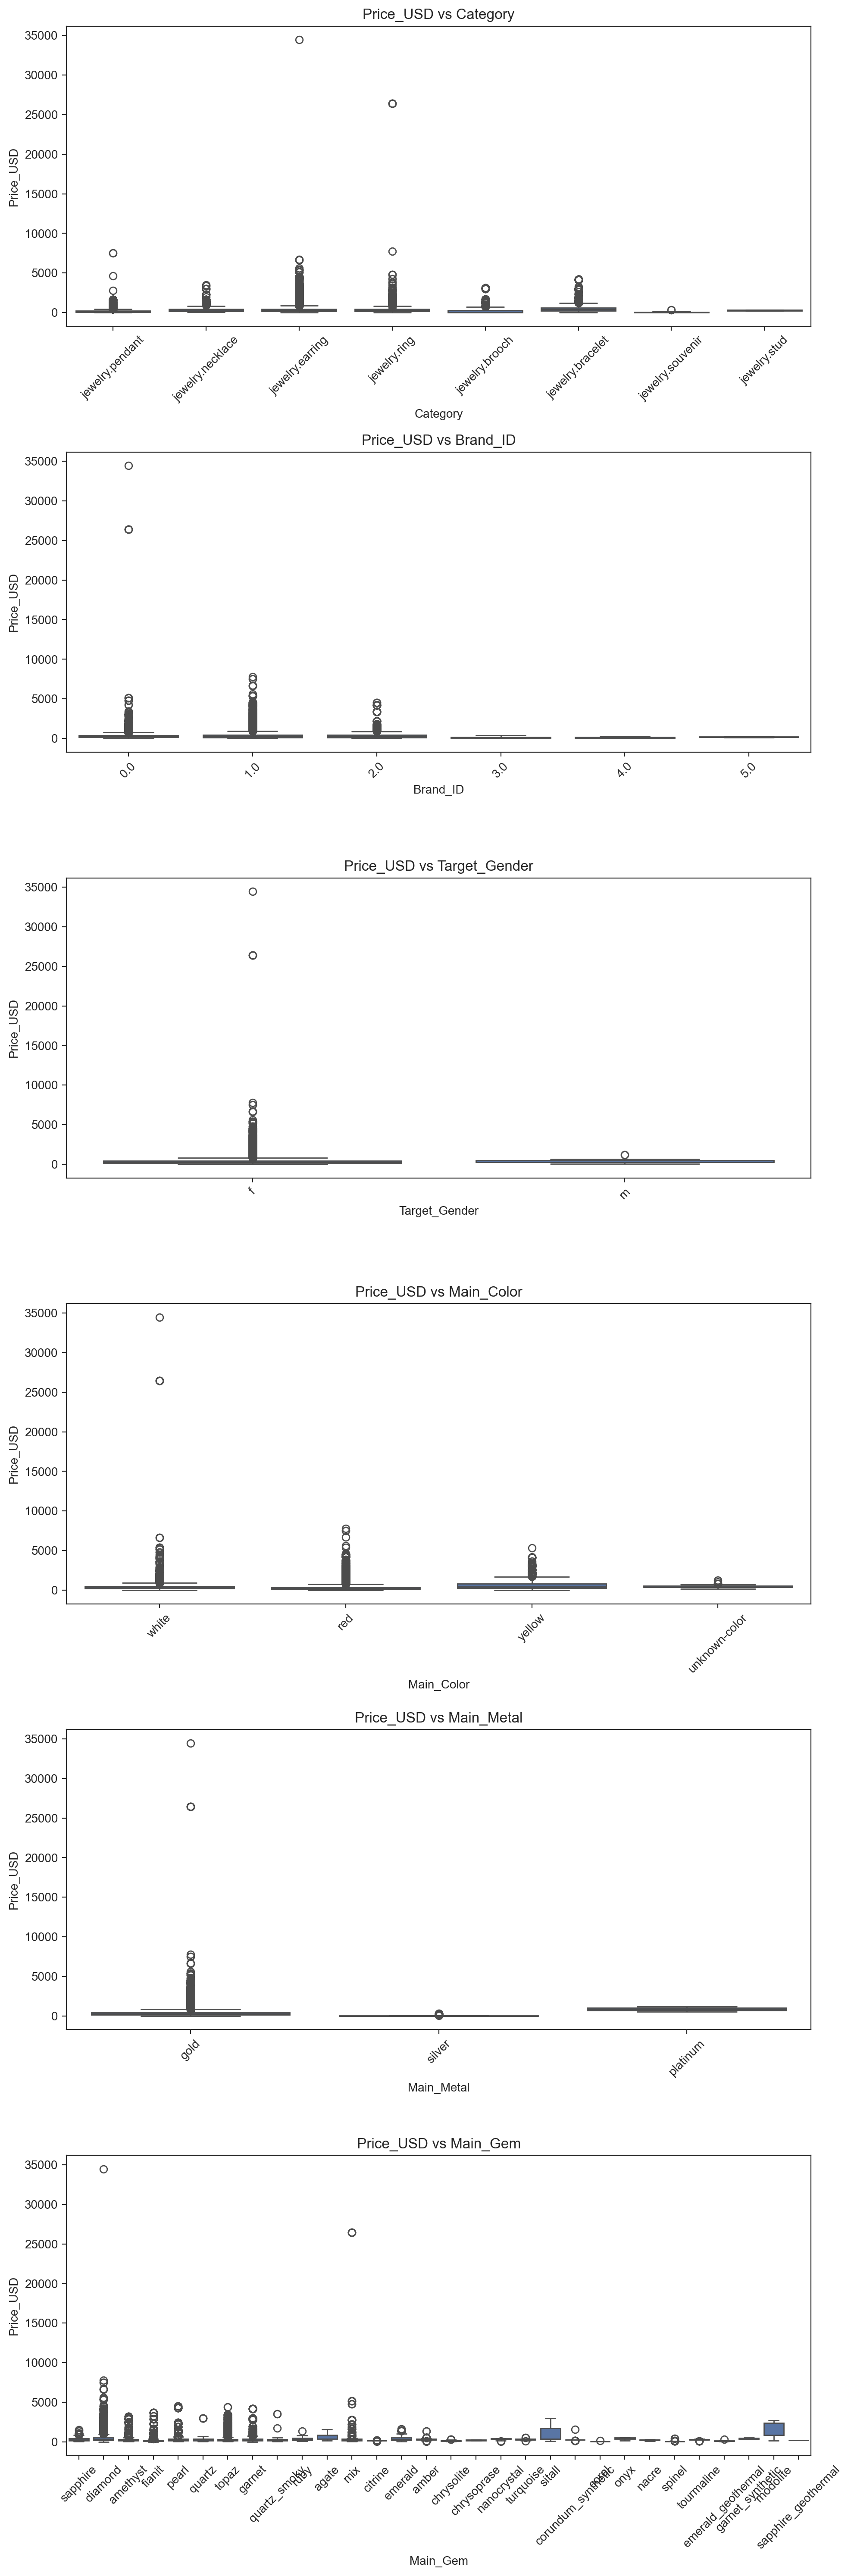

In [64]:
# List of categorical columns
categories = ['Category', 'Brand_ID', 'Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']

# Number of subplots
n = len(categories)

# Create subplots
fig, axes = plt.subplots(n, 1, figsize=(10, 5 * n))

for i, col in enumerate(categories):
    ax = axes[i] if n > 1 else axes  # For single subplot case
    sns.boxplot(data=df_cleaned, x=col, y='Price_USD', ax=ax)
    ax.set_title(f'Price_USD vs {col}')
    ax.set_ylabel('Price_USD')
    ax.set_xlabel(col)
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability if necessary

plt.tight_layout()
plt.show()


# 2.4.1 Outlier Removal

In [65]:
# Fit Isolation Forest on the data
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df_cleaned['Outlier'] = iso_forest.fit_predict(df_cleaned[['Price_USD']])

# Filter out detected outliers
new_df_no_outliers = df_cleaned[df_cleaned['Outlier'] == 1].drop(columns=['Outlier'])

# Rename the cleaned dataset
cleaned_data = new_df_no_outliers

# Display the first few rows of the cleaned data
print(cleaned_data.shape)
cleaned_data.describe()


(77322, 7)


Brand_ID     Price_USD
count  77322.000000  77322.000000
mean       0.603981    327.710149
std        0.689024    273.791523
min        0.000000      0.990000
25%        0.000000    142.330000
50%        0.000000    247.950000
75%        1.000000    412.050000
max        5.000000   1887.670000

In [ ]:
# Check dataset shape
print(f"The Dataset shape is: {cleaned_data.shape}, after duplicates and outliers removed")

The Dataset shape is: (77322, 7)
----------------------------------


Category         0
Brand_ID         0
Price_USD        0
Target_Gender    0
Main_Color       0
Main_Metal       0
Main_Gem         0
dtype: int64

In [53]:
# Save DataFrame to CSV
csv_file_name = 'jewellery_cleaned_data.csv'
cleaned_data.to_csv(csv_file_name, index=False)

print(f"DataFrame successfully saved to {csv_file_name}")

DataFrame successfully saved to jewellery_cleaned_data.csv


# Comment:

**Outlier Identification:** Detected 804 outliers using the Isolation Forest algorithm. Outliers removed to avoid distortion in the model.

**Final dataset:** 79,654 rows, 7 features (including price).

# 3.0 Advanced Correlation Analysis -Phik Correlation Heatmap

Available columns in DataFrame:
Index(['Category', 'Brand_ID', 'Price_USD', 'Target_Gender', 'Main_Color',
       'Main_Metal', 'Main_Gem'],
      dtype='object')


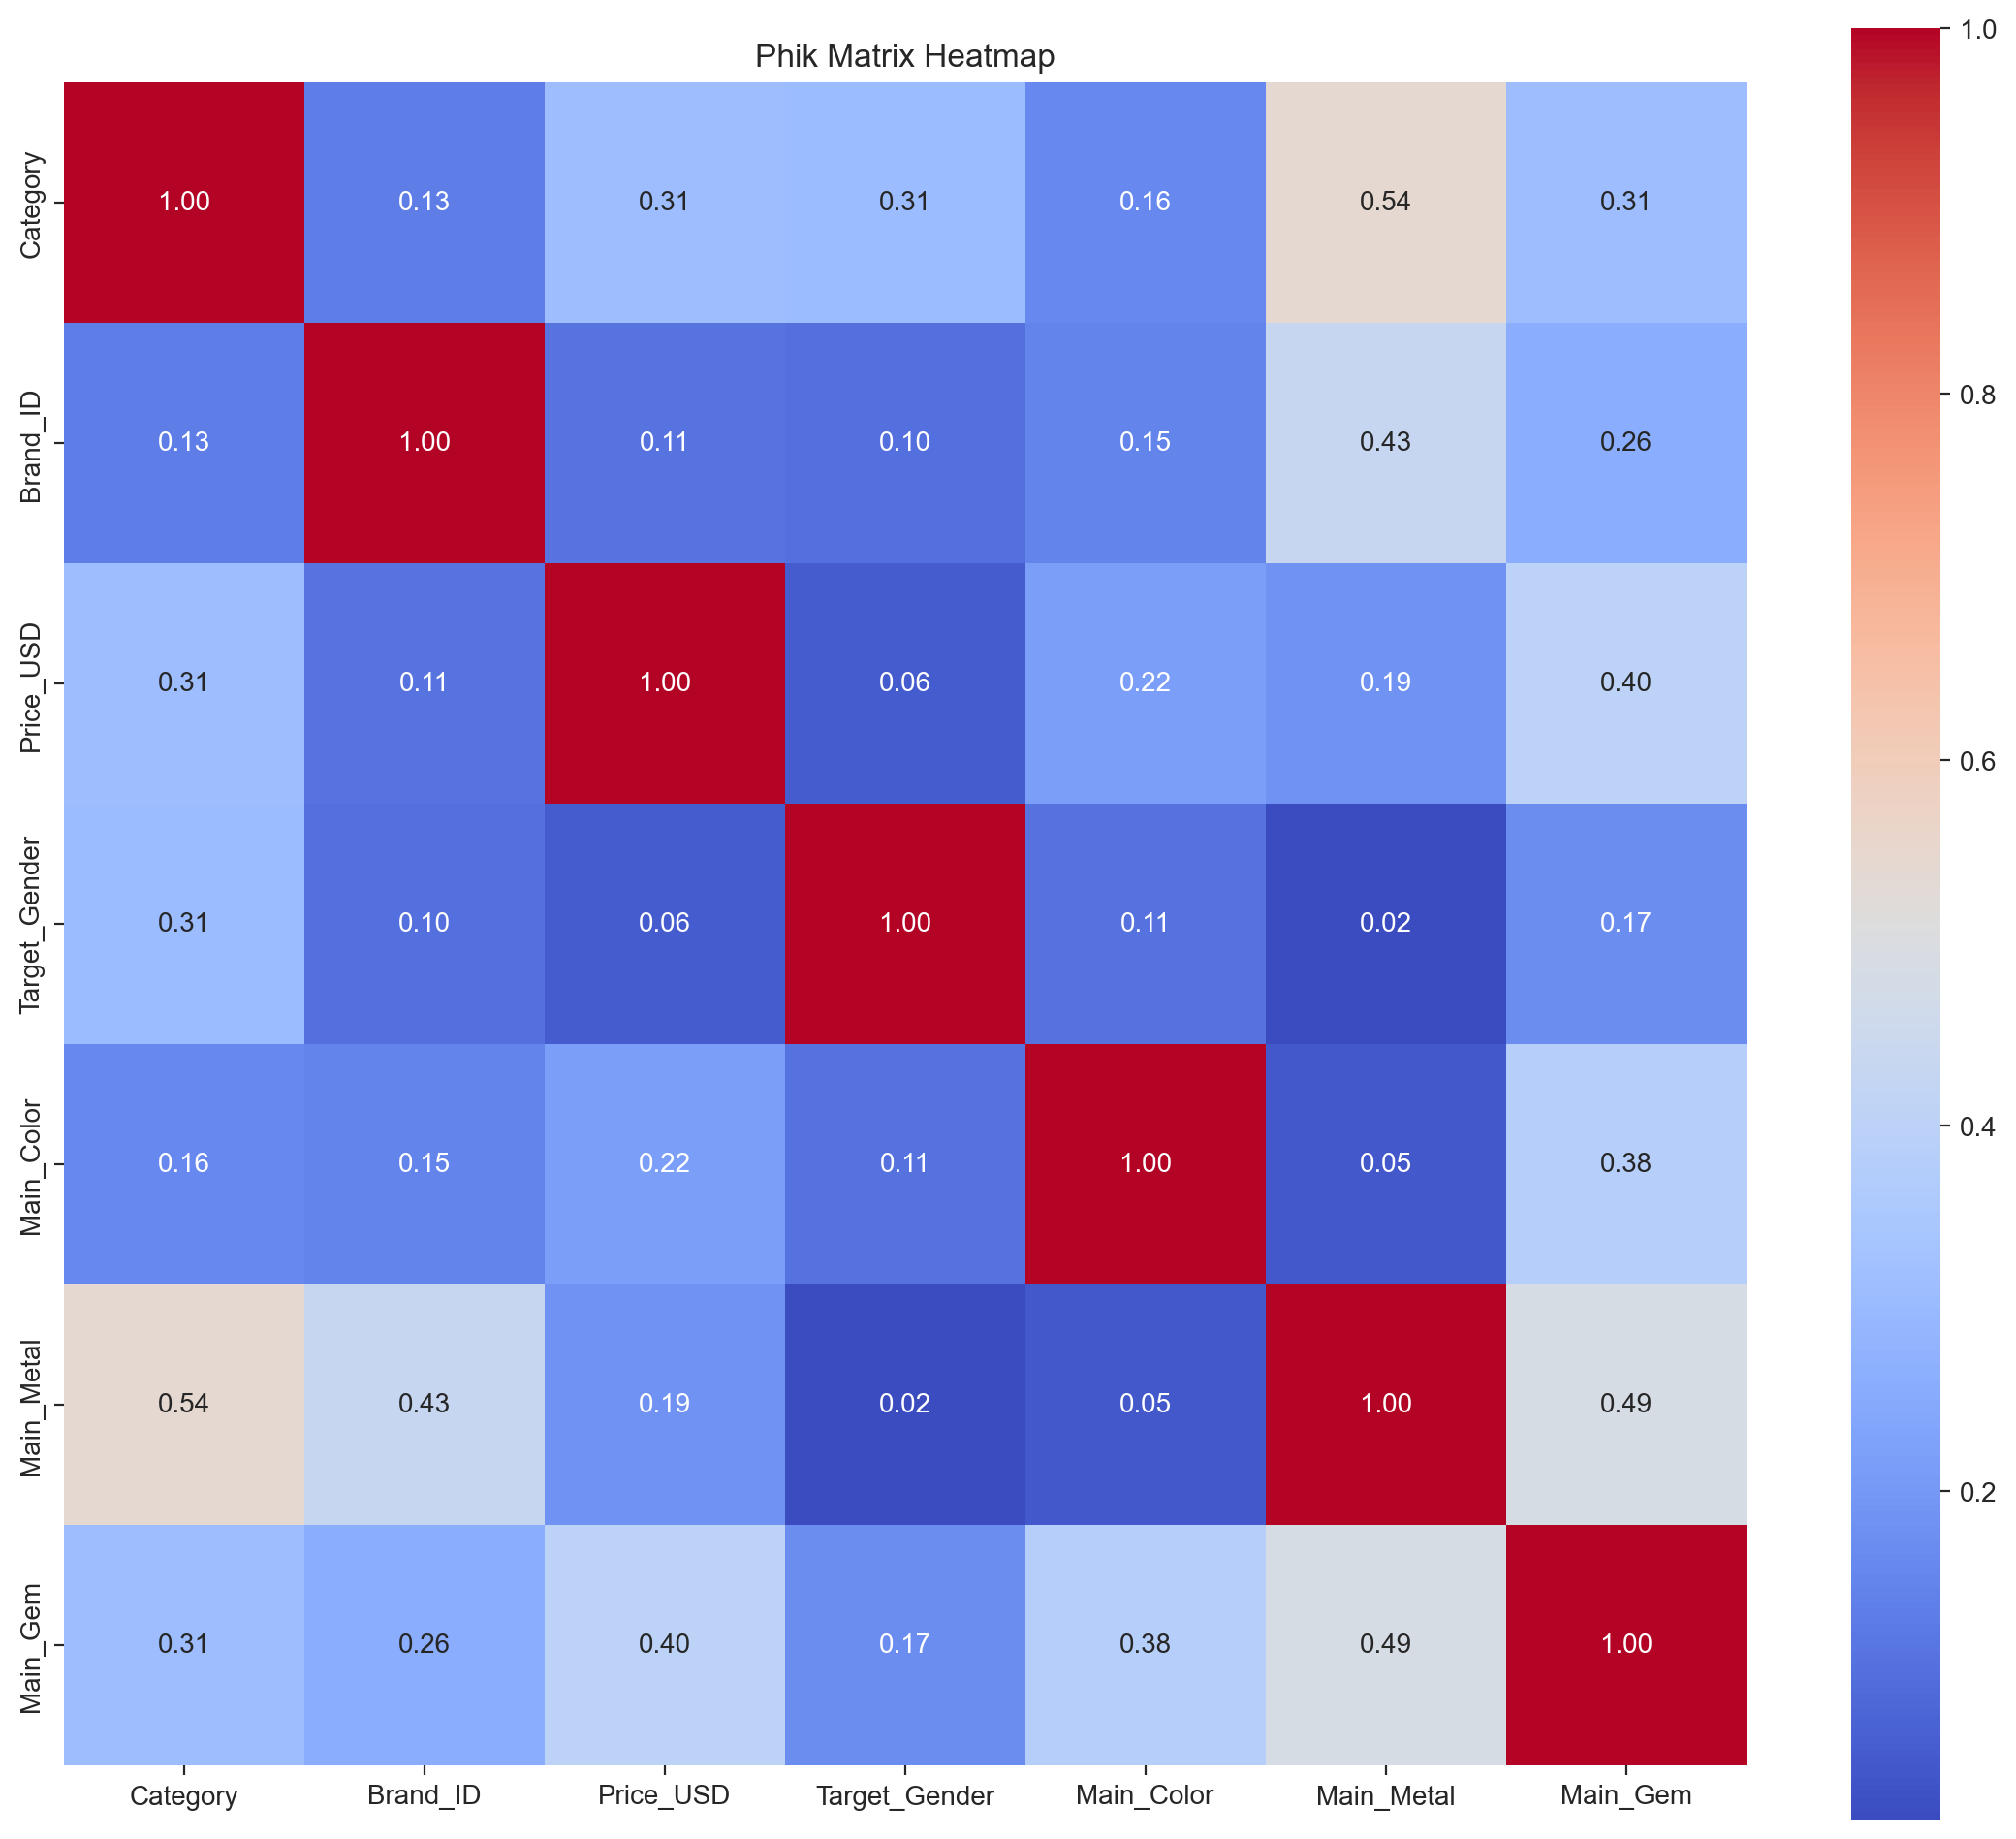

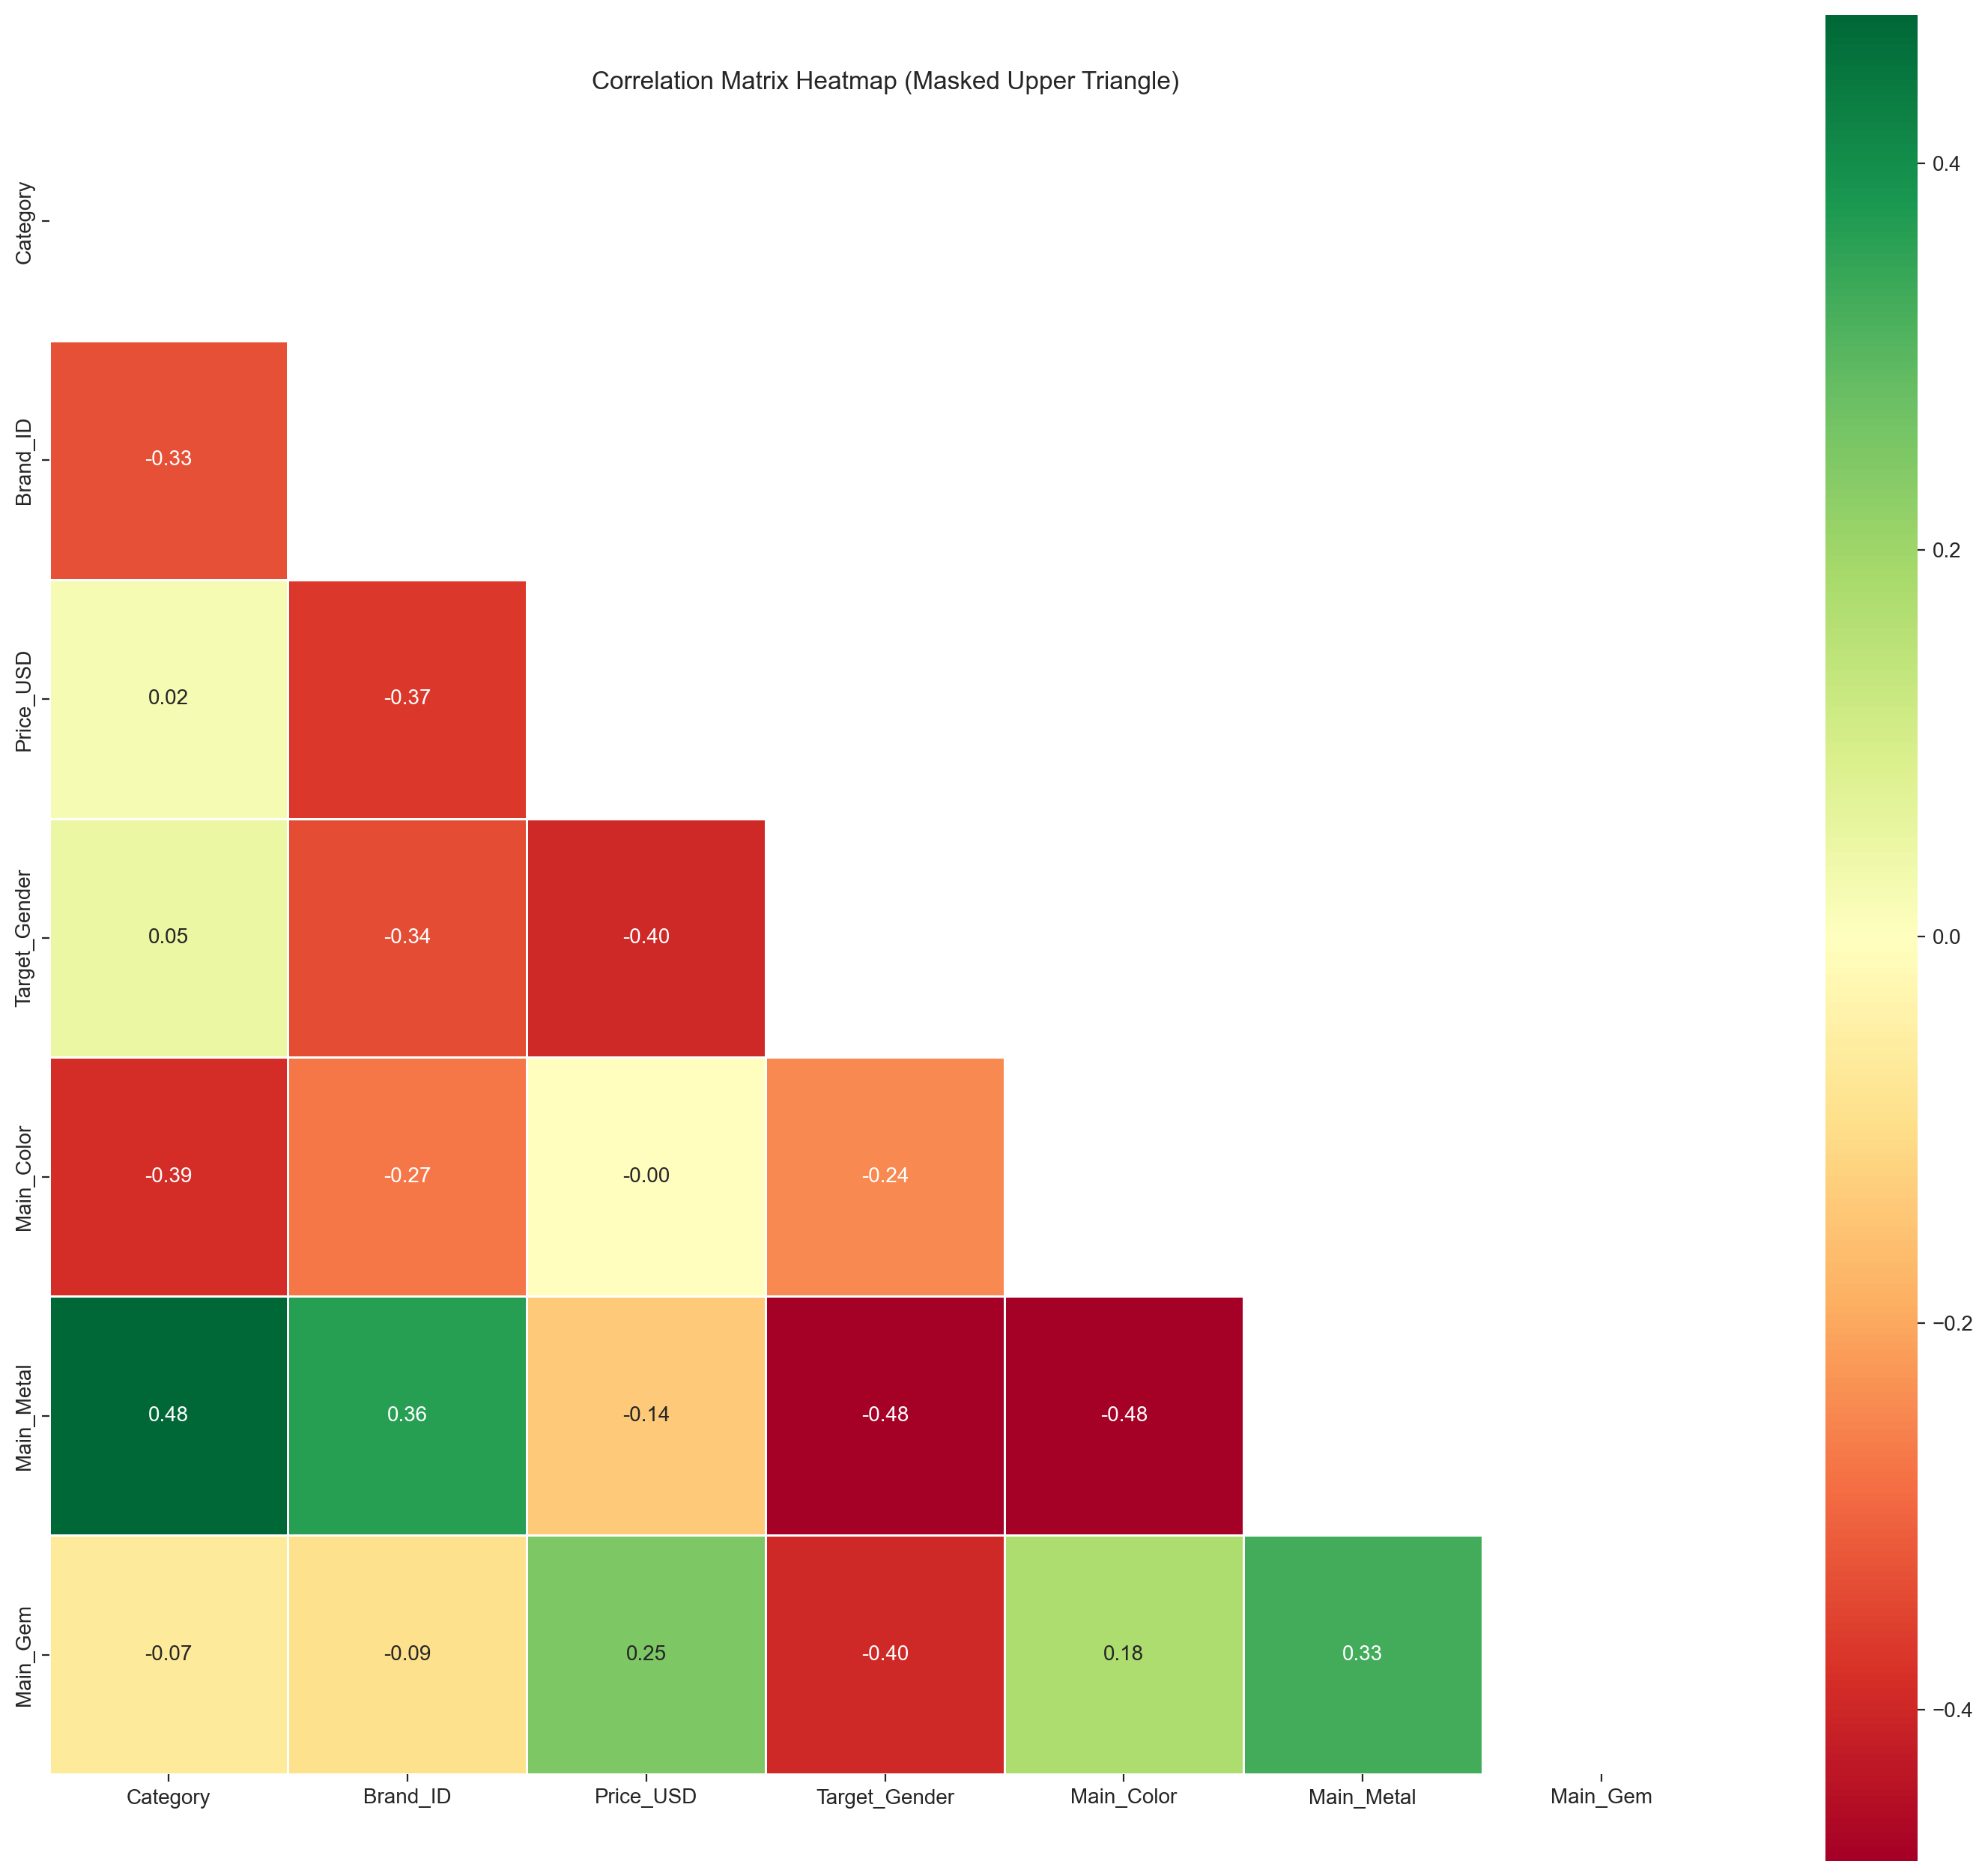

In [54]:
# Convert to DataFrame
df = pd.DataFrame(cleaned_data)

# Display available columns in the DataFrame
print("Available columns in DataFrame:")
print(df.columns)

# Ensure the 'Price_USD' column exists
if 'Price_USD' not in df.columns:
    raise KeyError("'Price_USD' column not found. Please check the correct column name.")

# Select numerical columns for Phik interval calculations
interval_cols = df.select_dtypes(include='number').columns

# Compute Phik matrix
phik_matrix_df = df.phik_matrix(interval_cols=interval_cols)

# Plot the Phik Matrix Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(phik_matrix_df, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10}, square=True)
plt.title("Phik Matrix Heatmap")
plt.show()

# Calculate the correlation matrix from the Phik matrix
corr_matrix = phik_matrix_df.corr()

# Create a mask for the upper triangle using NumPy's triu function
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the heatmap with the mask applied
plt.figure(figsize=(18, 16))
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    square=True, 
    annot=True, 
    cmap='RdYlGn', 
    linewidths=0.5, 
    fmt=".2f", 
    annot_kws={"size": 10}
)
plt.title("Correlation Matrix Heatmap (Masked Upper Triangle)")
plt.show()


# Comment

**Feature Selection**

**Advanced Correlation Analysis - Phik Heatmap Results:**

**Strong associations:**

  * Main_Metal and Category (Phik = 0.541).
  * Main_Metal and Main_Gem (Phik = 0.487).

**Moderate associations:**

  * Price_USD with Category (Phik = 0.315).
  * Price_USD with Main_Gem (Phik = 0.401).

**Weaker associations:**

  * Target_Gender with Main_Metal (Phik = 0.020).


# 4.0 Model Selection, Training, Evaluation and MLflow set-up 

**1. Chosen Models** 

**RandomForestRegressor, XGBRegressor, GradientBoostingRegressor, LGBMRegressor:**

  * Selected for their strong performance in regression tasks and ability to handle nonlinear relationships.
  * These models are known for their robustness, scalability, and hyperparameter tuning flexibility.

**2. Hyperparameter Tuning and Results:** 

  * Models were optimized using GridSearchCV for hyperparameter tuning

**3. Evaluation Metrics**

**Chosen Metrics:**

**i. R² (Coefficient of Determination):** Measures goodness of fit.

**ii. MAE (Mean Absolute Error):** Evaluates average prediction error.

**ii. MSE (Mean Squared Error):** Penalizes larger errors to assess overall variance.

Metrics align with regression task objectives and provide a holistic evaluation.

**4. MLflow Integration**

**Tracking Setup:**

  * Used to log hyperparameters, training performance, and metrics.

Tuning Random Forest...
Best parameters for RandomForestRegressor: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Performance:
MAE: 152.10494135293183, MSE: 52880.265101142424, R²: 0.2784046586939025

Random Forest Performance:
MAE: 152.54647926986823, MSE: 53122.25847755106, R²: 0.297971818600301



2024/12/02 20:35:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://localhost:5000/#/experiments/1/runs/87d35d244a8d476ba83f7729ae425c28
🧪 View experiment at: http://localhost:5000/#/experiments/1
Tuning XGBoost...
Best parameters for XGBRegressor: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 300}
XGBoost Performance:
MAE: 152.0032751695819, MSE: 52876.5867631344, R²: 0.2784548526852765

XGBoost Performance:
MAE: 152.40839600582837, MSE: 53104.45500373779, R²: 0.298207097383657



2024/12/02 20:36:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://localhost:5000/#/experiments/1/runs/5601cacb668648b8b78d0515d9680000
🧪 View experiment at: http://localhost:5000/#/experiments/1
Tuning Gradient Boosting...
Best parameters for GradientBoostingRegressor: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
Gradient Boosting Performance:
MAE: 152.06066718604615, MSE: 52923.18714462481, R²: 0.2778189515958578

Gradient Boosting Performance:
MAE: 152.411088761217, MSE: 53104.46986794988, R²: 0.2982069009481876



2024/12/02 20:44:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Gradient Boosting at: http://localhost:5000/#/experiments/1/runs/feec2309d8bf44c3aef92ad9c17c65da
🧪 View experiment at: http://localhost:5000/#/experiments/1
Tuning LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 54125, number of used features: 38
[LightGBM] [Info] Start training from score 329.481753
Best parameters for LGBMRegressor: {'learning_rate': 0.3, 'max_depth': 31, 'n_estimators': 300}
LightGBM Performance:
MAE: 152.71788741300767, MSE: 52998.786681581274, R²: 0.2767873328328213

LightGBM Performance:
MAE: 153.22004991795063, MSE: 53333.85409243663, R²: 0.2951755127020297



2024/12/02 20:45:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM at: http://localhost:5000/#/experiments/1/runs/ec1e0a2ecc0c4a05a79f6530c58b9774
🧪 View experiment at: http://localhost:5000/#/experiments/1


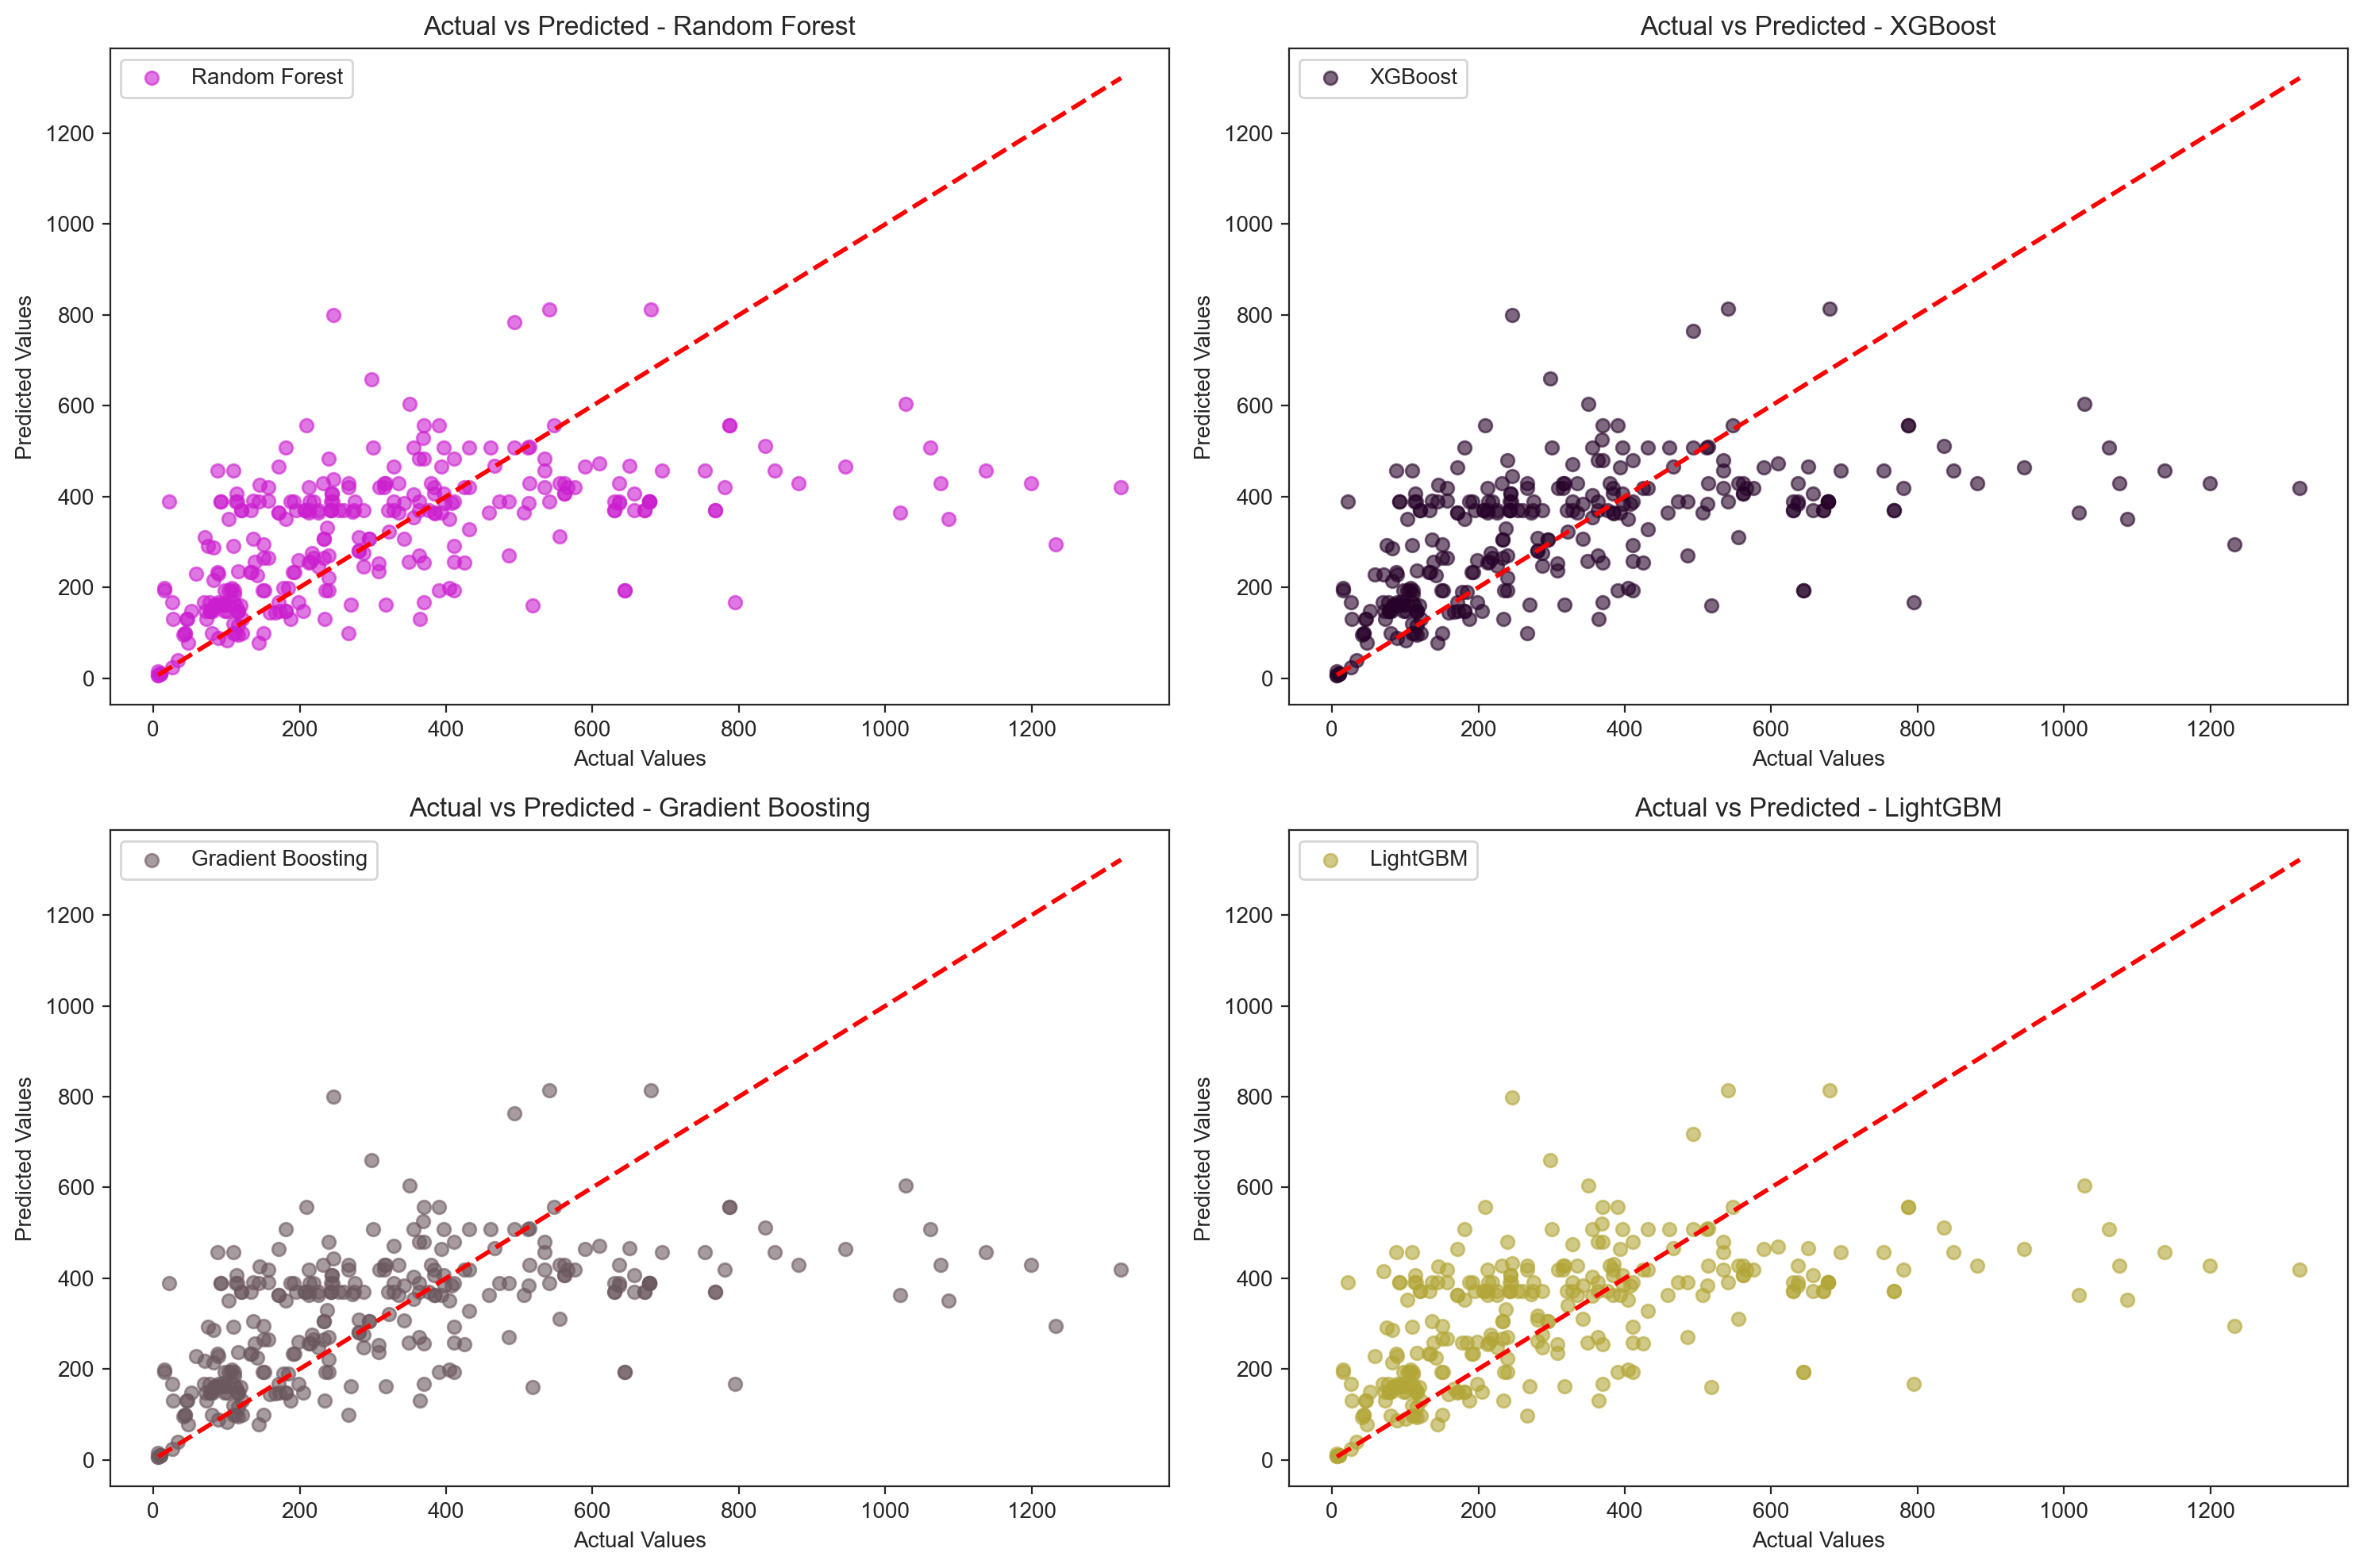

Comparison DataFrame (First 5 Instances):
       Actual Values  Random Forest Predicted  Random Forest Difference  \
6628          239.59               221.845143              1.774486e+01   
24320        1136.85               457.455899              6.793941e+02   
10284           6.71                 6.710000              1.953993e-14   
4058          657.40               370.487391              2.869126e+02   
60369         207.45               370.487391              1.630374e+02   

       XGBoost Predicted  XGBoost Difference  Gradient Boosting Predicted  \
6628          221.804199           17.785801                   221.877063   
24320         457.325745          679.524255                   457.293823   
10284           6.716130            0.006130                     6.813386   
4058          370.395477          287.004523                   370.398182   
60369         370.395477          162.945477                   370.398182   

       Gradient Boosting Difference  LightGB

In [55]:
# MLflow Setup
mlflow.set_tracking_uri(uri="http://localhost:5000")
mlflow.set_experiment("Jewelry Price Optimization")

def split_data(df, target_column='Price_USD', test_size=0.3, random_state=42):
    """
    Split the dataset into train and test sets.
    """
    X = df.drop(columns=[target_column])
    y = df[target_column]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def create_pipeline():
    """
    Create preprocessing pipeline for filling missing values and encoding categorical variables.
    """
    categorical_features = ['Category', 'Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']
    numerical_features = ['Brand_ID']

    # Pipelines for numerical and categorical preprocessing
    cat_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    num_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Combine into a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pipeline, numerical_features),
            ('cat', cat_pipeline, categorical_features)
        ]
    )
    return preprocessor

def preprocess_data(X_train, X_test, preprocessor):
    """
    Apply preprocessing steps to train and test datasets.
    """
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    return X_train, X_test

def evaluate_model(y_test, preds, model_name):
    """
    Evaluate the model's performance using MAE, MSE, and R².
    """
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae}, MSE: {mse}, R²: {r2}\n")
    return mae, mse, r2

def tune_hyperparameters(model, param_grid, X_train, y_train):
    """
    Perform grid search with cross-validation for hyperparameter tuning.
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    return grid_search

def log_model_with_mlflow(model, model_name, X_train, y_train):
    """
    Log the model and its metrics using MLflow.
    """
    with mlflow.start_run(run_name=model_name):
        mlflow.log_params(model.best_params_)
        mlflow.log_metric("train_score", model.best_score_)

        # Logging metrics
        preds = model.best_estimator_.predict(X_train)
        mae, mse, r2 = evaluate_model(y_train, preds, model_name)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("MSE", mse)
        mlflow.log_metric("R2", r2)

        # Log the model itself
        mlflow.sklearn.log_model(model.best_estimator_, model_name)

def plot_actual_vs_predicted(y_test, preds_dict, num_instances=300):
    """
    Plot Actual vs Predicted values for all models.
    """
    y_test_subset = y_test[:num_instances]
    plt.figure(figsize=(15, 10))
    for i, (model_name, preds) in enumerate(preds_dict.items(), 1):
        preds_subset = preds[:num_instances]
        plt.subplot(2, 2, i)
        plt.scatter(y_test_subset, preds_subset, alpha=0.6, label=model_name, color=np.random.rand(3,))
        plt.plot([y_test_subset.min(), y_test_subset.max()], [y_test_subset.min(), y_test_subset.max()], color='red', lw=2, linestyle='--')
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title(f"Actual vs Predicted - {model_name}")
        plt.legend()
    plt.tight_layout()
    plt.show()

def compare_predictions(y_test, preds_dict, num_instances=5):
    """
    Create a DataFrame to compare actual vs predicted values for the first few instances.
    """
    comparison_data = {"Actual Values": y_test[:num_instances].values}
    for model_name, preds in preds_dict.items():
        comparison_data[f"{model_name} Predicted"] = preds[:num_instances]
        comparison_data[f"{model_name} Difference"] = abs(y_test[:num_instances] - preds[:num_instances])
    comparison_df = pd.DataFrame(comparison_data)
    print("Comparison DataFrame (First 5 Instances):")
    print(comparison_df)
    return comparison_df

# Main workflow
def main():
    # Assuming 'cleaned_data' is your dataset
    X_train, X_test, y_train, y_test = split_data(cleaned_data)

    # Create and apply preprocessing pipeline
    preprocessor = create_pipeline()
    X_train, X_test = preprocess_data(X_train, X_test, preprocessor)

    # Hyperparameter grids for all models
    rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5]}
    xgb_params = {'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [5, 7, 10], 'n_estimators': [100, 200, 300]}
    gbr_params = {'learning_rate': [0.05, 0.1, 0.2], 'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}
    lgbm_params = {'max_depth': [31, 50], 'learning_rate': [0.05, 0.1, 0.3], 'n_estimators': [100, 200, 300]}

     
    # Initialize models
    models = [
        (RandomForestRegressor(random_state=42), rf_params, "Random Forest"),
        (XGBRegressor(random_state=42), xgb_params, "XGBoost"),
        (GradientBoostingRegressor(random_state=42), gbr_params, "Gradient Boosting"),
        (LGBMRegressor(random_state=42), lgbm_params, "LightGBM")
    ]

    preds_dict = {}
    # Tune, evaluate, log, and collect predictions
    for model, params, name in models:
        print(f"Tuning {name}...")
        tuned_model = tune_hyperparameters(model, params, X_train, y_train)
        preds = tuned_model.best_estimator_.predict(X_test)
        preds_dict[name] = preds
        evaluate_model(y_test, preds, name)
        log_model_with_mlflow(tuned_model, name, X_train, y_train)

    # Plot Actual vs Predicted
    plot_actual_vs_predicted(y_test, preds_dict)

    # Compare predictions
    compare_predictions(y_test, preds_dict)

# Run the pipeline
if __name__ == "__main__":
    main()


# 4.1 Model Evaluation Comparison

In [56]:
# Model results
model_names = ['Random Forest', 'XGBoost', 'Gradient Boosting', 'LightGBM']
mae = [152.55, 152.41, 152.41, 153.22]
mse = [53122.26, 53104.45, 53104.47, 53333.85]
r2 = [0.2980, 0.2982, 0.2982, 0.2952]

# Create a dictionary for the results
results_dict = {
    'Model': model_names,
    'MAE (USD)': mae,
    'MSE (USD²)': mse,
    'R² Score': r2
}

# Create a DataFrame
results_df = pd.DataFrame(results_dict)

# Sort the DataFrame by a specific column (e.g., 'MAE (USD)')
sorted_results_df = results_df.sort_values(by='R² Score', ascending=False)

# Display the results
sorted_results_df


Model  MAE (USD)  MSE (USD²)  R² Score
1            XGBoost     152.41    53104.45    0.2982
2  Gradient Boosting     152.41    53104.47    0.2982
0      Random Forest     152.55    53122.26    0.2980
3           LightGBM     153.22    53333.85    0.2952

# Comment:

**Best parameters identified for each model:**

**RandomForestRegressor:** max_depth=30, min_samples_split=2, n_estimators=100

**XGBRegressor:** learning_rate=0.2, max_depth=10, n_estimators=300.

**GradientBoostingRegressor:** learning_rate=0.2, max_depth=7, n_estimators=300.

**LGBMRegressor:** learning_rate=0.3, max_depth=31, n_estimators=300.

# Conclusion and Recommendations

**Model Performance Summary:**

**Best algorithm: GradientBoostingRegressor with the highest R² (0.294).**

  * Other models had comparable but slightly lower R² scores (~0.29).
  * Results indicate limited predictive power, suggesting that the current dataset lacks sufficient features and data quality to model jewelry prices effectively, as seen in the Scatterplot graph plotted above.

**Insights from the Data:**

  * Key influencing features: Category, Main_Metal, Main_Gem, Price_USD.
  * Limited diversity in gender and metal preferences observed.

**Recommendations to Jewelry Management**

**1. Invest in Data Quality and Expansion**

  * Current dataset: 95,910 rows reduced by 16% due to errors.

**Limitations:**

  * Lack of diverse and detailed features, e.g., customer demographics, promotional campaigns, and purchasing patterns.
  * Insufficient data samples for certain categories (e.g., male buyers and less common gems/metals).

**Action Plan:**

  * Collect more comprehensive data with a focus on:
  * Customer behavior: Age, location, income level.
  * Product features: Design specifications, customization options, and seasonal trends.
  * Sales history: Discounts, bundling, and cross-sales patterns.

**2. Improve Feature Engineering**

Include additional variables such as:

  * Jewelry weight, purity levels, and certification.
  * Marketing influences (ads, promotions).
  * Seasonality and regional trends.

**3. Leverage Insights for Business Strategy**

  * Focus marketing efforts on female customers, particularly those purchasing earrings, rings, and pendants.
  * Increase inventory and promotions for popular items (e.g., gold jewelry with diamonds).
  * Develop targeted campaigns for male buyers to increase engagement in niche categories like rings.

**Final Note**

Investing in data quality, expanding feature diversity, and leveraging insights for strategic decision-making will empower the company to optimize pricing strategies, improve operational efficiency, and enhance profitability.